# The Street View House Numbers (SVHN) Dataset

- http://ufldl.stanford.edu/housenumbers/

## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os
import sys
import imp
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import torchvision as tv
import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False
Python 3.6.0 |Anaconda custom (x86_64)| (default, Dec 23 2016, 13:19:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [6]:
train_trafo = tv.transforms.Compose([
    tv.transforms.RandomCrop(30),
    tv.transforms.ToTensor(),
])
valid_trafo = tv.transforms.Compose([
    tv.transforms.CenterCrop(30),
    tv.transforms.ToTensor(),
])

train_ds = tv.datasets.SVHN('/data/datasets/Google_SVHN_2/', split='train', 
                            transform=train_trafo, 
                           )

valid_ds = tv.datasets.SVHN('/data/datasets/Google_SVHN_2/', split='test', 
                            transform=valid_trafo, 
                           )

In [7]:
if 0:
    # reduz quantidade de dados para testes iniciais
    Mt, Mv = 5000, 2000
    valid_ds.data = valid_ds.data[:Mv]
    train_ds.data = train_ds.data[:Mt]
    valid_ds.labels = valid_ds.labels[:Mv]
    train_ds.labels = train_ds.labels[:Mt]

8 torch.Size([3, 30, 30]) 0.7647058963775635


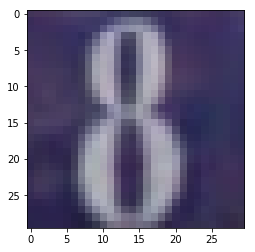

In [9]:
ii = np.random.randint(len(train_ds))
image, label = train_ds[ii]
print(label, image.shape, image.max())
plt.imshow(image.numpy().transpose(1, 2, 0))


In [10]:
batch_size = 20
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [11]:
def compute_accuracy(logits, labels):
    _, preds = torch.max(logits.data, 1)
    return (preds == labels.data).type(torch.FloatTensor).sum()

In [18]:
class MyNet(nn.Module):
    # Input size is (-1, 3, 30, 30)
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [19]:
trainIt = False
resetIt = False

# Callbacks
# ---------
accuracy_cb = ptt.AccuracyMetric()
chkpt_cb = ptt.ModelCheckpoint('../../models/svhn_01', reset=resetIt, verbose=1)
print_cb = ptt.PrintCallback()
plot_cb = ptt.PlotCallback()

# Model, optimizer and learning rate scheduler
# --------------------------------------------
model = MyNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

# Network trainer
# ---------------
training_parameters = {
    'model':         model, 
    'criterion':     nn.CrossEntropyLoss(),
    'optimizer':     optimizer, 
    'lr_scheduler':  scheduler, 
    'callbacks':     [accuracy_cb, chkpt_cb, print_cb, plot_cb],
}
trainer = ptt.DeepNetTrainer(**training_parameters)

In [20]:
if trainIt:
    trainer.fit_loader(10, train_dl, valid_dl)
else:
    trainer.load_state('/data/models/svhn_01')
    print('\nTraining disabled.\nThis model was trained for {} epochs.'.format(trainer.last_epoch))


Training disabled.
This model was trained for 12 epochs.


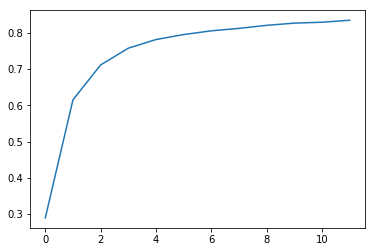

In [25]:
plt.plot(trainer.metrics['train']['acc'])

In [26]:
metrics = trainer.evaluate_loader(train_dl, metrics=[ptt.AccuracyMetric()])
print('Model training set accuracy after training: {:.5f}'.format(metrics['acc']))
print()
metrics = trainer.evaluate_loader(valid_dl, metrics=[ptt.AccuracyMetric()])
print('Model validation set accuracy after training: {:.5f}'.format(metrics['acc']))

evaluate: 3662/3662 ok
Model training set accuracy after training: 0.83431

evaluate: 1301/1301 ok
Model validation set accuracy after training: 0.84296
